In [1]:
import sys
sys.path.append("../")
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import src.preprocessing as pp


In [2]:
identifiers = ["date_id_a", "match_a", "wave_a", 
"date_id_b",  "wave_b"]

# same as 1_1
#preference = ["pf_o_att_a", "pf_o_sin_a", "pf_o_int_a", "pf_o_fun_a", "pf_o_amb_a", "pf_o_sha_a", 
#"pf_o_att_b", "pf_o_sin_b", "pf_o_int_b", "pf_o_fun_b", "pf_o_amb_b", "pf_o_sha_b"]

personal_info = ["field_cd_a", "age_a", "race_a", "income_a", "zipcode_a", "samerace_a", "goal_a",
"field_cd_b", "age_b", "race_b", "income_b", "zipcode_b", "goal_b", "distance_bin", "zipcode_area_b", "zipcode_area_a"]

behaviour = ["go_out_a", "sports_a", "tvsports_a", "exercise_a", "dining_a", "museums_a", "art_a", "hiking_a", "gaming_a",
           "clubbing_a", "reading_a", "tv_a", "theater_a", "movies_a", "concerts_a", "music_a", "shopping_a",
           "yoga_a", "exphappy_a",
           "go_out_b", "sports_b", "tvsports_b", "exercise_b", "dining_b", "museums_b", "art_b", "hiking_b", "gaming_b",
           "clubbing_b", "reading_b", "tv_b", "theater_b", "movies_b", "concerts_b", "music_b", "shopping_b",
           "yoga_b", "exphappy_b"]

difference_hobbies = ["go_out_df", "sports_df", "tvsports_df", "exercise_df", "dining_df", "museums_df", "art_df", "hiking_df", "gaming_df",
           "clubbing_df", "reading_df", "tv_df", "theater_df", "movies_df", "concerts_df", "music_df", "shopping_df", "yoga_df", "exphappy_df"]

hobbies_big_diff = ["go_out_df_big", "sports_df_big", "tvsports_df_big", "exercise_df_big", "dining_df_big", "museums_df_big", "art_df_big", "hiking_df_big", "gaming_df_big",
           "clubbing_df_big", "reading_df_big", "tv_df_big", "theater_df_big", "movies_df_big", "concerts_df_big", "music_df_big", "shopping_df_big", "yoga_df_big", "exphappy_df_big"]

looking_for = ["attr1_1_a", "sinc1_1_a", "intel1_1_a", "fun1_1_a", "amb1_1_a", "imprace_a", "imprelig_a",
"attr1_1_b", "sinc1_1_b", "intel1_1_b", "fun1_1_b", "amb1_1_b", "imprace_b", "imprelig_b"]

self_rating = [ "attr3_1_a", "sinc3_1_a", "intel3_1_a", "fun3_1_a", "amb3_1_a", "attr3_1_b", "sinc3_1_b", "intel3_1_b", "fun3_1_b", "amb3_1_b"]

# difference between what person a i slooking for b what person a rates themselves 1_1_a and 3_1_b
difference = ["attr_b_a", "sinc_b_a", "intel_b_a", "fun_b_a", "amb_b_a", "attr_a_b", "sinc_a_b", "intel_a_b", "fun_a_b", "amb_a_b"]

to_drop = ["date_id_a", "date_id_b", "wave_a", "wave_b", "zipcode_a", "zipcode_b"] #TODO clean text in from column , 

to_keep = personal_info + identifiers + difference + hobbies_big_diff + difference_hobbies

categorical = ["income_a", "income_b", "distance_bin", "zipcode_area_a", "zipcode_area_b"]


In [3]:
# read in data
df = pd.read_csv("../data/interim/single_row_date.csv")
df = df[to_keep]
df.drop(to_drop, axis = 1, inplace = True)

x = df.match_a.value_counts()
x[0]/(x[1]+x[0])

0.834248455730954

In [43]:
df = pd.get_dummies(df, columns = categorical)
# replace "Not applicable" with -1
df.columns[df.isnull().any()].tolist()
df.isnull().sum().sort_values(ascending=False).head(10)
df.dropna(inplace=True)

In [44]:
X = df[[column for column in df.columns if column!="match_a"]]
y = df["match_a"]

In [45]:
# splitting the data into testing and training sets. 70% for training, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.30, stratify=y, shuffle=True
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("baseline accuracy:", (len(y_test)-sum(y_test))/len(y_test))

(2000, 108) (2000,)
(858, 108) (858,)
baseline accuracy: 0.8333333333333334


In [46]:
# linear neural network
def neuralNet(X_train, Y_train, X_test, Y_test):

    input_dim = X_train.shape[1]

    # define model
    model = Sequential()
    model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    # fit model to the training data
    model.fit(X_train, Y_train, epochs=100, verbose=False, validation_data=(X_test, Y_test), batch_size=10)

    # evaluate accuracies for train and test set
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))

    # predict on train dataset
    Y_train_pred = model.predict(X_train)

    # Predict the response for test dataset
    Y_test_pred = model.predict(X_test)

    # convert to class
    threshold = 0.5
    Y_train_pred = [1 if x >= threshold else 0 for x in Y_train_pred]
    Y_test_pred = [1 if x >= threshold else 0 for x in Y_test_pred]

    pp.scoring_func(y_test, Y_test_pred)

    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                1090      
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.8570
Testing Accuracy:  0.8275
27/27 [==============================] - 0s 821us/step
Precision: 0.41935483870967744
Recall: 0.09090909090909091
Accuracy: 0.8275058275058275
F1 Score: 0.14942528735632185


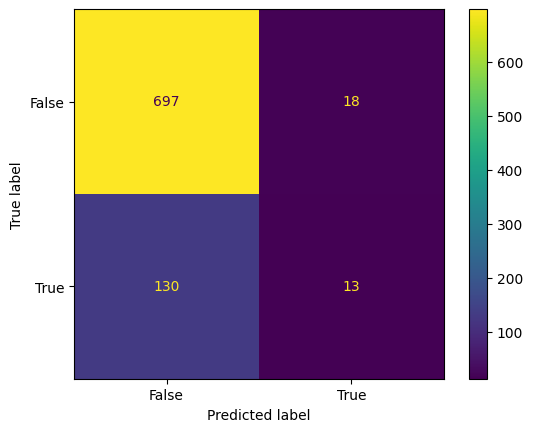

In [47]:
neuralNet(X_train, y_train, X_test, y_test)